In [88]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from matplotlib.cm import get_cmap

import seaborn as sns
import geopandas as gpd
from pathlib import Path
import pycountry
from copy import deepcopy

from pathlib import Path

from region_grouper import coarse_regions
idx = pd.IndexSlice

sys.path.append(str(Path.cwd()))
print(sys.path)

"""
from _plot_helpers import (
    get_data,
    group_df,
    get_displaced_capacity,
    make_region_mapper,
    dict_list,
    )
"""
carrier_mapper = {
    "elec": "geothermal heat elec",
    "chp": "geothermal heat chp elec",
    "dh": "geothermal heat dh",
}

def get_data(mode, op, process=True):

    if mode == "chp" or mode == "dh":
        df = pd.read_csv(
            root / f"{mode}_data" / 
            f"csvs_{op}" / 
            "nodal_capacities.csv", 
            index_col=[0,1,2], 
            header=[4,5,6]
            )
    elif mode == "elec":
        df = pd.read_csv(
            root / f"{mode}_data" / "csvs" / "nodal_capacities.csv",
            index_col=[0,1,2],
            header=[4,5,6]
            )
    
    if process:

        df.index = df.index.droplevel(0)
        df = df.loc[idx[:, carrier_mapper[mode]], idx[:,:,op]]

        df.index = df.index.get_level_values(0)
        df.columns = df.columns.get_level_values(0)

    return df

# group df index by dictionary with list
def group_df(df, mapper):
    
        result = pd.DataFrame(columns=df.columns)
    
        for key, value in mapper.items():
    
            result.loc[key] = df.loc[value, :].sum(axis=0)
    
        return pd.DataFrame(result)


def get_displaced_capacity(
        df,
        col,
        exclude_geothermal=True
        ):

    df = deepcopy(df)



    if exclude_geothermal:
        carriers = df.index.get_level_values(2).unique()
        others = [c for c in carriers if not "geothermal" in str(c)] 
        df = df.loc[idx[:, :, others], :]

    if not isinstance(col, pd.Series):
        col = df.loc[:, col]
     
    if len(df.index.difference(col.index)):
        print("reservoir in storage unit df but not in col; removing it")

        if 'geothermal heat' in df.loc[idx[["storage_units"],:,:]].index.get_level_values(2):
            remove_idx = df.loc[idx[["storage_units"]], :, ["geothermal heat"]].index

            df.drop(index=remove_idx, inplace=True)
    df = pd.DataFrame(
        np.subtract(df.values, col.values[:,None]),
        index=df.index,
        columns=df.columns,
        ).mul(1e-3)

    return df


def dict_list(dict):
    aslist = list()

    for value in dict.values():
        aslist += value

    return aslist



['c:\\Users\\lukas\\OneDrive\\Desktop\\projects\\egs\\coding\\basic_egs\\notebooks', 'c:\\Users\\lukas\\miniforge3\\envs\\pypsa-eur\\python310.zip', 'c:\\Users\\lukas\\miniforge3\\envs\\pypsa-eur\\DLLs', 'c:\\Users\\lukas\\miniforge3\\envs\\pypsa-eur\\lib', 'c:\\Users\\lukas\\miniforge3\\envs\\pypsa-eur', '', 'c:\\Users\\lukas\\miniforge3\\envs\\pypsa-eur\\lib\\site-packages', 'c:\\Users\\lukas\\miniforge3\\envs\\pypsa-eur\\lib\\site-packages\\win32', 'c:\\Users\\lukas\\miniforge3\\envs\\pypsa-eur\\lib\\site-packages\\win32\\lib', 'c:\\Users\\lukas\\miniforge3\\envs\\pypsa-eur\\lib\\site-packages\\Pythonwin', 'c:\\Users\\lukas\\OneDrive\\Desktop\\projects\\egs\\coding\\basic_egs\\notebooks', 'c:\\Users\\lukas\\OneDrive\\Desktop\\projects\\egs\\coding\\basic_egs\\notebooks', 'c:\\Users\\lukas\\OneDrive\\Desktop\\projects\\egs\\coding\\basic_egs\\notebooks', 'c:\\Users\\lukas\\OneDrive\\Desktop\\projects\\egs\\coding\\basic_egs\\notebooks', 'c:\\Users\\lukas\\OneDrive\\Desktop\\projects\

In [2]:
data_path = Path.cwd().parent.parent.parent / "cluster_data"
regions = gpd.read_file(data_path / "resources" / "regions_onshore_elec_s_72.geojson")
regions = regions.set_index("name")
regions["name"] = regions.index

def make_region_mapper():

    result = deepcopy(coarse_regions)
    covered = dict_list(result)

    for bus in regions.index:

        if bus in covered:
            continue

        result[pycountry.countries.get(alpha_2=bus[:2]).name] = [bus]

    return result

mapper = make_region_mapper()
reverse_mapper = dict()

for key, values in mapper.items():
    for value in values:
        reverse_mapper[value] = key

regions["region"] = regions["name"].apply(lambda entry: reverse_mapper[entry])
regions

,geometry,name,region
name,,,
AL1 0,"POLYGON ((20.32207 39.91318, 20.39703 39.81809...",AL1 0,Albania
AT1 0,"POLYGON ((13.86068 46.51525, 13.67026 46.51871...",AT1 0,Austria
BA1 0,"POLYGON ((17.82716 42.85312, 17.81176 42.90986...",BA1 0,Bosnia and Herzegovina
BE1 0,"POLYGON ((4.68192 50.08392, 4.67292 50.01638, ...",BE1 0,Belgium
BG1 0,"POLYGON ((23.94989 41.43758, 23.89480 41.46434...",BG1 0,Bulgaria
...,...,...,...
RS1 0,"POLYGON ((20.75050 41.90680, 20.72331 41.86662...",RS1 0,Serbia
SE2 0,"MULTIPOLYGON (((12.97918 55.40327, 12.83277 55...",SE2 0,Sweden
SE2 1,"MULTIPOLYGON (((17.49916 61.72383, 17.45725 61...",SE2 1,Sweden


In [3]:
global root
root = Path.cwd().parent.parent.parent / "cluster_data"

Index(['Northern Spain', 'Sweden', 'England', 'Poland', 'Norway', 'Finland',
       'Central Germany', 'Northern France', 'Ireland', 'Romania',
       'Southern France', 'Central Italy', 'Netherlands', 'Scotland',
       'Belgium'],
      dtype='object')


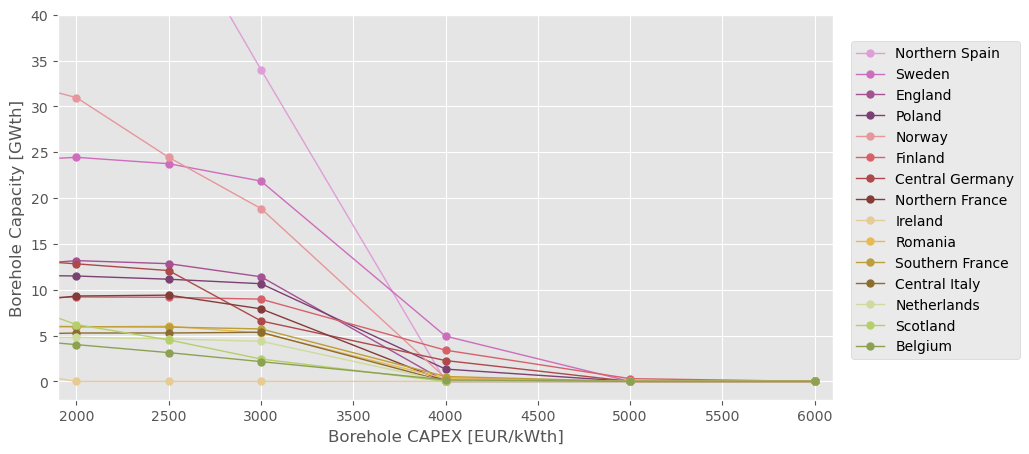

In [4]:
mode = "dh"
op = "static"

plot_regions = [
    'Northern Spain',
    'Sweden',
    'England',
    'Poland',
    'Norway',
    'Finland',
    'Central Germany',
    'Northern France',
    'Ireland',
    'Romania',
    'Southern France',
    'Central Italy',
    'Netherlands',
    'Scotland',
    'Belgium',
    ]

df = get_data(mode, op)
grouped = group_df(df, mapper)
grouped.columns = grouped.columns.astype(int)

n_show = 15

cmap = get_cmap("tab20b")
colors = cmap.colors[::-1]

plot = grouped.sort_values(by=6000, ascending=False).mul(1e-3)

if plot_regions:
    plot = plot.loc[plot_regions, :]
else:
    plot = plot.iloc[:n_show, :]

fig, ax = plt.subplots(figsize=(10, 5))

ax.set_prop_cycle(color=colors)
plot.T.plot(ax=ax, marker="o", linewidth=1, markersize=5)

ax.set_ylabel("Borehole Capacity [GWth]")
ax.set_xlabel("Borehole CAPEX [EUR/kWth]")
# ax.set_yscale("log")

ax.legend(
    bbox_to_anchor=(1.25, 0.95),
    fancybox=True,
    shadow=False,
    ncol=1,
    )
ax.set_xlim(1900, 6100)
ax.set_ylim(-2, 40)

print(plot.index)

plt.savefig(f"capex_vs_expansion_{mode}.pdf")
plt.show()

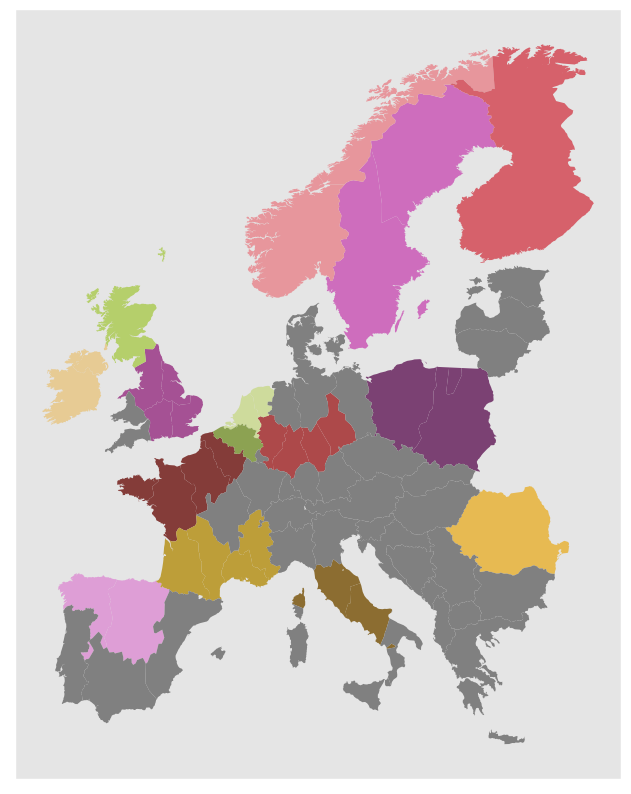

In [5]:
fig, ax = plt.subplots(figsize=(20, 10))

for reg, color in zip(plot.index, colors):
    regions.loc[regions["region"] == reg].plot(ax=ax, color=color)

regions.loc[~regions["region"].isin(plot.index)].plot(ax=ax, color="gray")

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])

plt.show()

In [6]:
df = get_data("dh", "static", process=False)

col = df.columns[-1]
diff = get_displaced_capacity(df, col)

In [7]:
import yaml
with open(Path.cwd().parent / "config" / "config.yaml", "r") as f:
    tech_colors = yaml.safe_load(f)["plotting"]["tech_colors"]

#### Single operational model

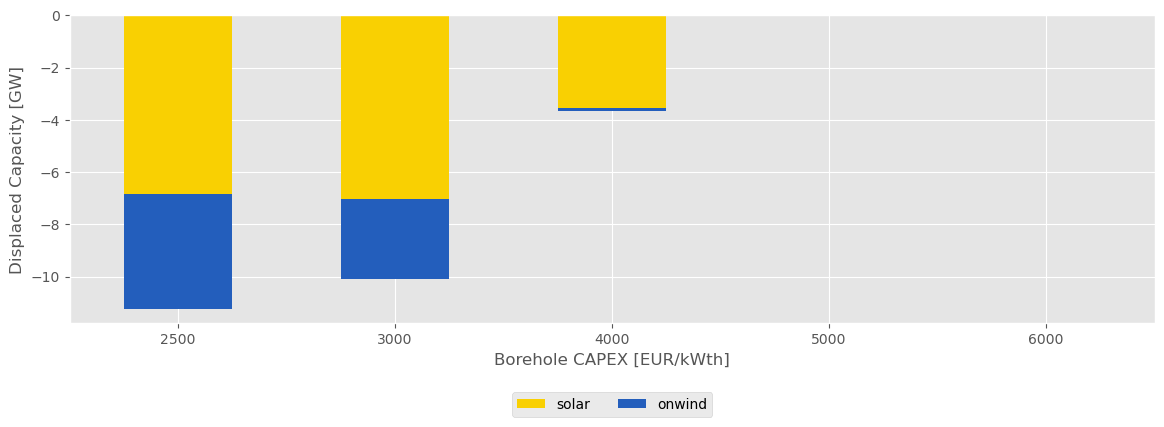

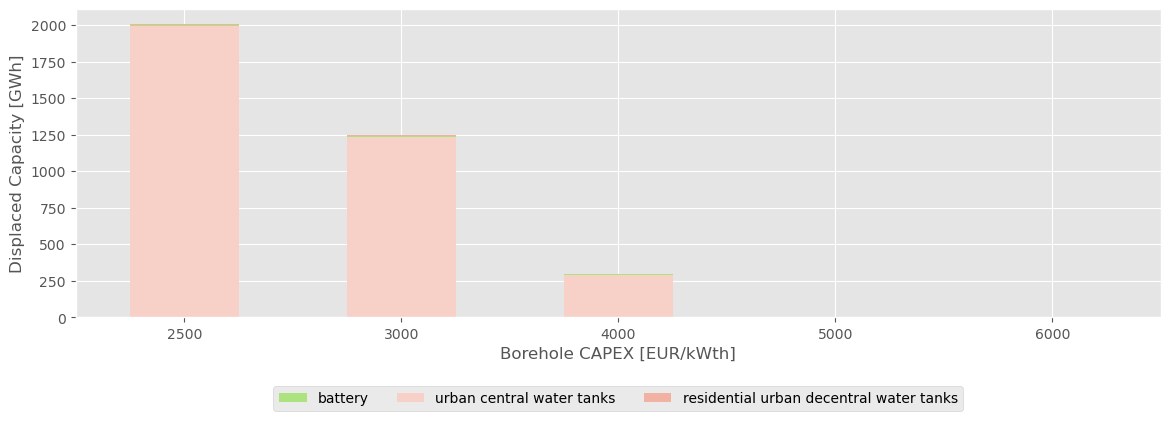

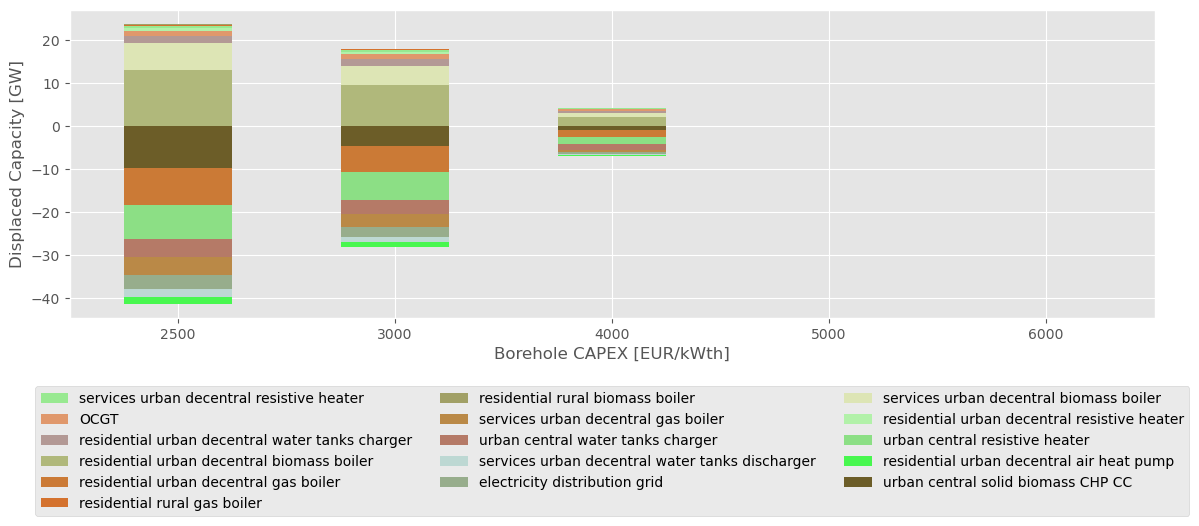

In [11]:
from matplotlib.patches import Patch

plot_regions = "Central Germany"
n_show_carriers = 16
units = {
    "generators": "GW",
    "links": "GW",
    "stores": "GWh",
    }

drop_thresholds = {
    "generators": 0.1,
    "links": 0.1,
    "stores": 10,
}

for c in diff.index.get_level_values(0).unique():

    if c in ["lines", "progress", "storage_units"]:
        continue

    ss = diff.loc[idx[c,:,:], :]
    ss.index = ss.index.droplevel(0)

    ss = ss.loc[idx[mapper[plot_regions], :], :].groupby(level=1).sum()
    ss.columns = ss.columns.get_level_values(0).astype(int)

    ss = ss.iloc[:,2:]

    ss_negative = pd.DataFrame(np.minimum(ss.values, 0), index=ss.index, columns=ss.columns)
    ss_positive = pd.DataFrame(np.maximum(ss.values, 0), index=ss.index, columns=ss.columns)

    index = ss_negative.abs().sort_values(by=2500, ascending=False).index[:n_show_carriers//2]
    ss_negative = ss_negative.loc[index, :]

    index = ss_positive.sort_values(by=2500, ascending=False).index[:n_show_carriers//2]
    ss_positive = ss_positive.loc[index, :]

    fig, ax = plt.subplots(figsize=(14, 4))

    # print(ss_negative.sum(axis=1))
    ss_negative = ss_negative.loc[ss_negative.sum(axis=1) < -drop_thresholds[c], :]

    if not ss_negative.empty:
        ss_negative.T.plot(kind="bar",
            stacked=True,
            color=[tech_colors[c] for c in ss_negative.index],
            legend=False,
            ax=ax,
            )

    ss_positive = ss_positive.loc[ss_positive.sum(axis=1) > drop_thresholds[c], :]

    if not ss_positive.empty:
        ss_positive.T.plot(kind="bar",
            stacked=True,
            color=[tech_colors[c] for c in ss_positive.index],
            legend=False,
            ax=ax,
            )

    legend_elements = [
        Patch(facecolor=tech_colors[carrier], label=carrier)
        for carrier in set(ss_negative.index.tolist() + ss_positive.index.tolist())
    ]
    ax.legend(
        handles=legend_elements,
        loc='upper center',
        bbox_to_anchor=(0.5, -0.2),
        fancybox=True,
        shadow=False,
        ncol=3,
        )

    # rotate xticklabels
    for tick in ax.get_xticklabels():
        tick.set_rotation(0)
    ax.set_xlabel("Borehole CAPEX [EUR/kWth]")
    ax.set_ylabel(f"Displaced Capacity [{units[c]}]")

    plt.show()

#### Comparison of two operational styles

In [10]:
# method to remove doubled labels in legend
def remove_doubled_labels(handles):
    new_handles = []
    new_labels = []
    for handle, label in zip(handles, [h.get_label() for h in handles]):
        if label not in new_labels:
            new_handles.append(handle)
            new_labels.append(label)
    
    return new_handles

In [16]:
carrier_grouper = {
    "biomass heating": [
        # "urban central solid biomass CHP CC",
        "residential urban decentral biomass boiler",
        "services urban decentral biomass boiler",
    ],
    "gas heating": [
        "residential rural gas boiler",
        "residential urban decentral gas boiler",
    ],
    "water tanks (dis)charging": [
        "urban central water tanks discharger",
        "urban central water tanks charger",
        "residential urban central decentral water tanks charger",
        "residential rural water tanks charger",
        "services urban decentral water tanks discharger"
        "services rural water tanks charger",
    ],
    "battery (dis)charging": [
        "battery discharger",
        "battery charger",
    ]
}

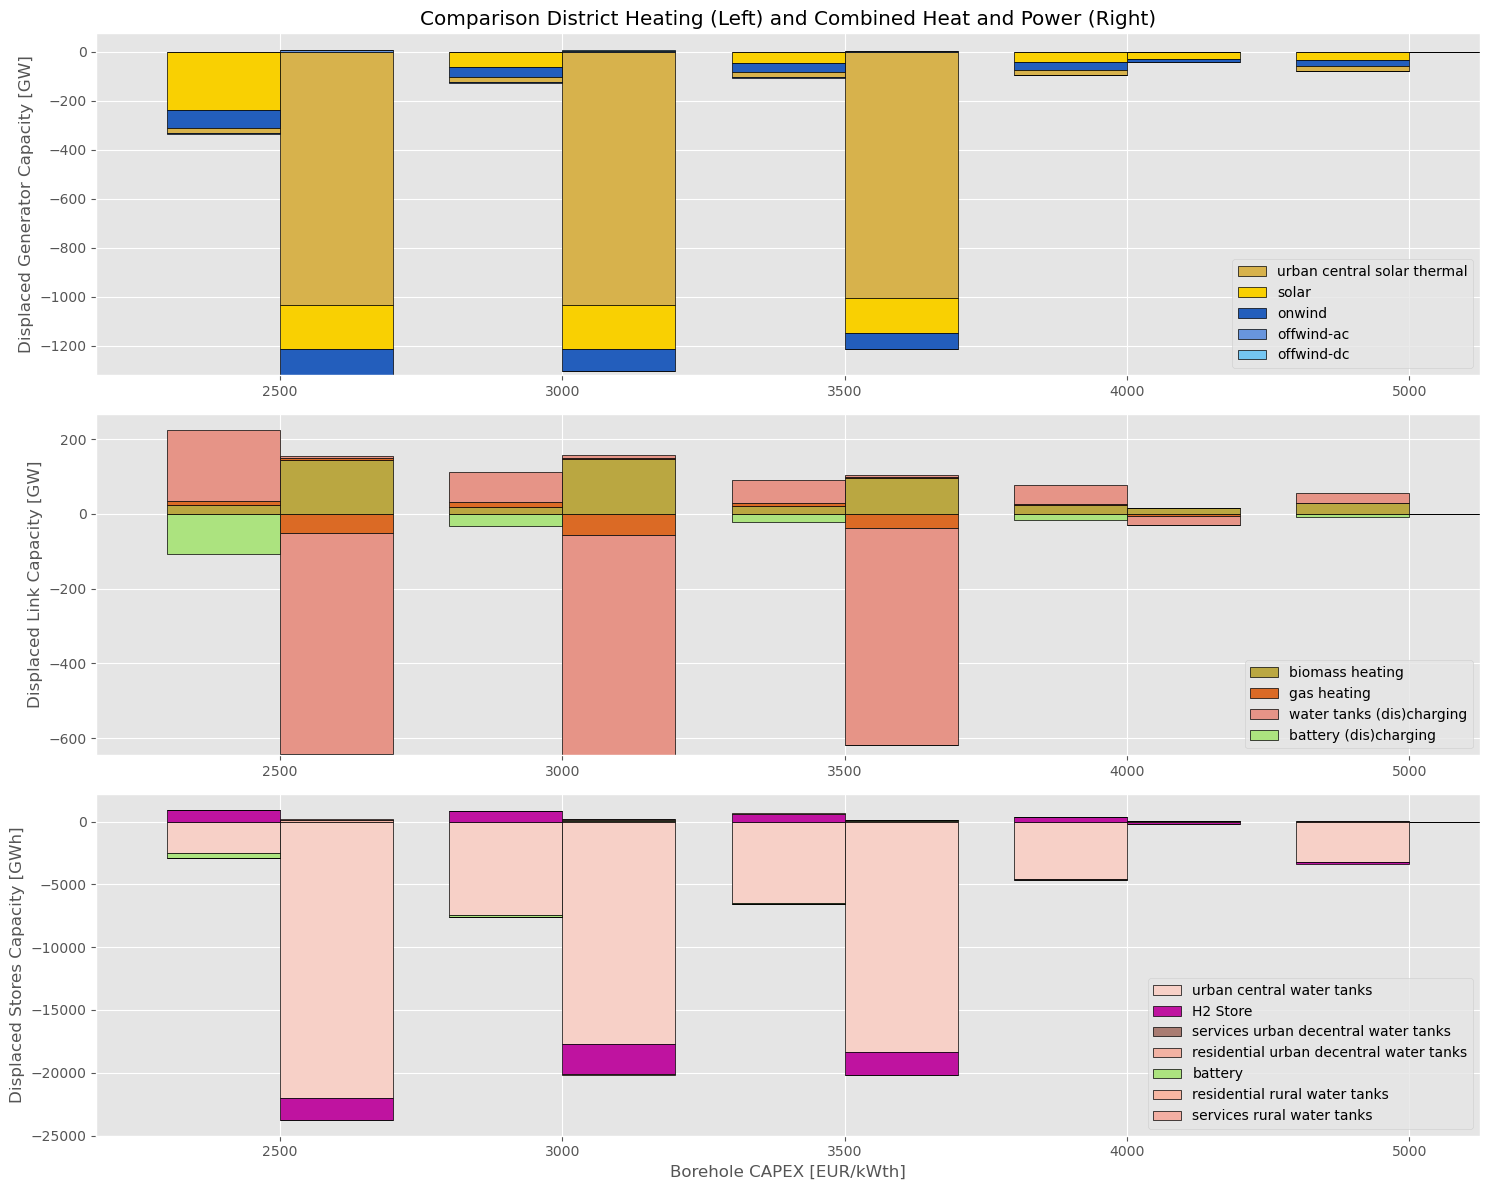

In [45]:
from matplotlib.patches import Patch

modes = ["dh", "chp"]

plot_regions = list(mapper)
# plot_regions = "Northern Spain"
# plot_regions = "Central Germany"
# plot_regions = "Austria"

n_show_carriers = 16
units = {
    "generators": "GW",
    "links": "GW",
    "stores": "GWh",
    }

drop_thresholds = {
    "generators": 0.1,
    "links": 0.1,
    "stores": 10,
}

fig, axs = plt.subplots(3, 1, figsize=(15, 12))
ax_selector = {
    c: i for i, c in enumerate(drop_thresholds.keys())
}

bar_kwargs = {
    'kind': "bar",
    'stacked': True,
    'legend': False,
    'width': 0.4,
    'edgecolor': 'k',
}

nice_mode_name = {
    "dh": "District Heating",
    "chp": "Combined Heat and Power",
    "elec": "Electricity",
}

for position, mode in enumerate(modes):

    df = get_data(mode, "static", process=False)

    col = df.columns[-1]
    diff = get_displaced_capacity(df, col)

    for c in diff.index.get_level_values(0).unique():

        if c in ["lines", "progress", "storage_units"]:
            continue
        ax = axs[ax_selector[c]]

        ss = diff.loc[idx[c,:,:], :]
        ss.index = ss.index.droplevel(0)

        if isinstance(plot_regions, str):
            ss = ss.loc[idx[mapper[plot_regions], :], :].groupby(level=1).sum()
        else:
            plot_buses = []
            for r in plot_regions:
                plot_buses += mapper[r]

            ss = ss.loc[idx[plot_buses, :], :].groupby(level=1).sum()
        
        ss.columns = ss.columns.get_level_values(0).astype(int)

        # ss = ss.iloc[:,1:]
        ss = ss[ss.columns[ss.columns > 1500.]]
        ss = ss[ss.columns[ss.columns < 6000.]]

        # if c == "stores":
        #     ss = ss.mul(1e-3)

        ss_negative = pd.DataFrame(np.minimum(ss.values, 0), index=ss.index, columns=ss.columns)
        ss_positive = pd.DataFrame(np.maximum(ss.values, 0), index=ss.index, columns=ss.columns)

        index = ss_negative.abs().sort_values(by=2500, ascending=False).index[:n_show_carriers//2]
        ss_negative = ss_negative.loc[index, :]

        index = ss_positive.sort_values(by=2500, ascending=False).index[:n_show_carriers//2]
        ss_positive = ss_positive.loc[index, :]

        # print(ss_negative.sum(axis=1))
        ss_negative = ss_negative.loc[ss_negative.sum(axis=1) < -drop_thresholds[c], :]

        if c == "links":
            ss_negative = pd.concat((
                ss_negative.loc[ss_negative.index.intersection(old_carriers)].sum().rename(new_carrier)
                for new_carrier, old_carriers in carrier_grouper.items()
            ), axis=1).T

            ss_positive = pd.concat((
                ss_positive.loc[ss_positive.index.intersection(old_carriers)].sum().rename(new_carrier)
                for new_carrier, old_carriers in carrier_grouper.items()
            ), axis=1).T

        if not ss_negative.empty:
            ss_negative.T.plot(
                color=[tech_colors[c] for c in ss_negative.index],
                ax=ax,
                position=position,
                **bar_kwargs,
                )
            
        ss_positive = ss_positive.loc[ss_positive.sum(axis=1) > drop_thresholds[c], :]

        if not ss_positive.empty:
            bars = ss_positive.T.plot(
                ax=ax,
                position=position,
                color=[tech_colors[c] for c in ss_positive.index],
                **bar_kwargs,
                )

        handles = ax.get_legend_handles_labels()

        new_legend_elements = [
            Patch(facecolor=tech_colors[carrier], label=carrier)
            for carrier in set(ss_negative.index.tolist() + ss_positive.index.tolist())
        ]

        handles = (
            handles[0] + new_legend_elements
        )

        handles = remove_doubled_labels(handles)

        ax.legend(
            handles=handles,
            # loc='upper center',
            # bbox_to_anchor=(1.01, 1.),
            # bbox_to_anchor=(0.5, -0.2),
            fancybox=True,
            shadow=False,
            ncol=1,
            # ncol=3,
            )

        for tick in ax.get_xticklabels():
            tick.set_rotation(0)

axs[0].set_ylabel(f"Displaced Generator Capacity [{units['generators']}]")
axs[1].set_ylabel(f"Displaced Link Capacity [{units['links']}]")
axs[2].set_ylabel(f"Displaced Stores Capacity [{units['stores']}]")

axs[-1].set_xlabel("Borehole CAPEX [EUR/kWth]")
axs[0].set_xlabel("")
axs[1].set_xlabel("")

axs[0].set_title(f"Comparison {nice_mode_name[modes[0]]} (Left) and {nice_mode_name[modes[1]]} (Right)")
plt.tight_layout()
plt.show()

##### Flexibility Analysis

reservoir in storage unit df but not in col; removing it
reservoir in storage unit df but not in col; removing it
reservoir in storage unit df but not in col; removing it
reservoir in storage unit df but not in col; removing it
reservoir in storage unit df but not in col; removing it
reservoir in storage unit df but not in col; removing it
reservoir in storage unit df but not in col; removing it


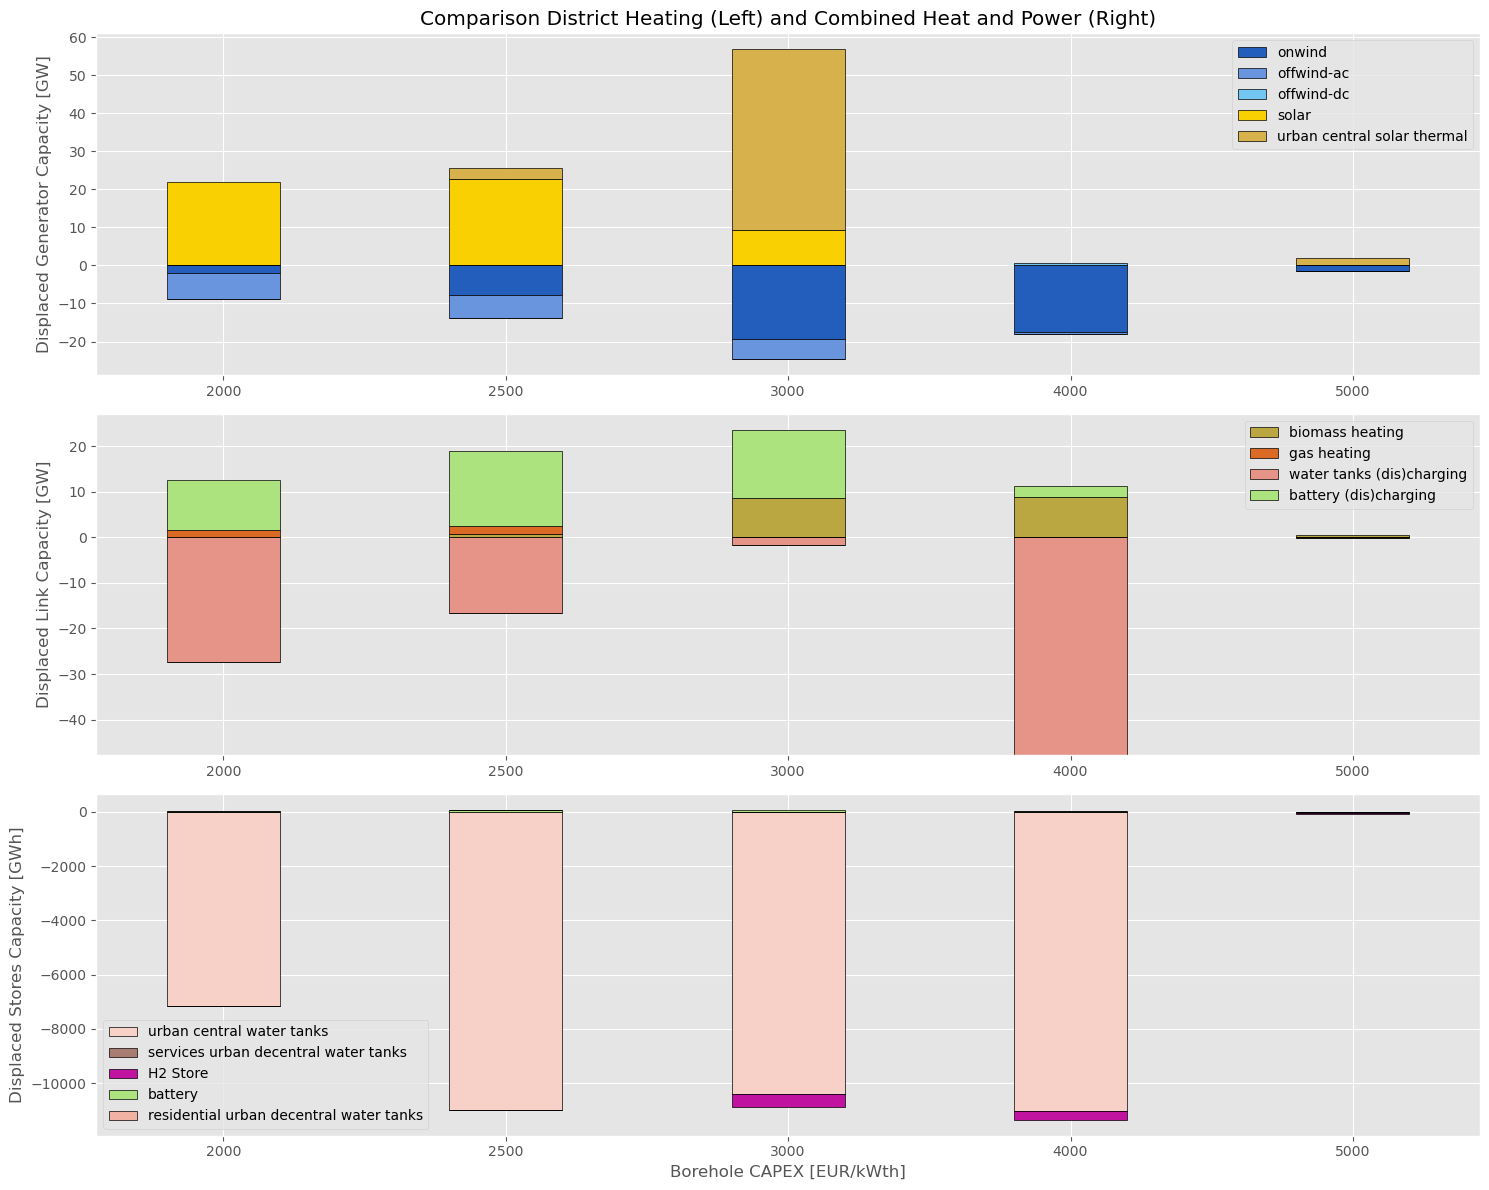

In [90]:
from matplotlib.patches import Patch

# modes = ["dh", "chp"]
mode = "dh"

plot_regions = list(mapper)

n_show_carriers = 16
units = {
    "generators": "GW",
    "links": "GW",
    "stores": "GWh",
    }

drop_thresholds = {
    "generators": 0.1,
    "links": 0.1,
    "stores": 10,
}

fig, axs = plt.subplots(3, 1, figsize=(15, 12))
ax_selector = {
    c: i for i, c in enumerate(drop_thresholds.keys())
}

bar_kwargs = {
    'kind': "bar",
    'stacked': True,
    'legend': False,
    'width': 0.4,
    'edgecolor': 'k',
}

nice_mode_name = {
    "dh": "District Heating",
    "chp": "Combined Heat and Power",
    "elec": "Electricity",
}

df_static = get_data(mode, "static", process=False)
df_flex = get_data(mode, "flex", process=False)

assert (df_static.columns.get_level_values(0) == df_flex.columns.get_level_values(0)).all()

diff = list()
for i, label in enumerate(df_static.columns):
    diff.append(get_displaced_capacity(
        df_flex.iloc[:,i:i+1],
        df_static.iloc[:,i],
        exclude_geothermal=False)
        )

# col = df.columns[-1]
# diff = get_displaced_capacity(df, col)
diff = pd.concat(diff, axis=1, keys=df_static.columns)

for c in diff.index.get_level_values(0).unique():

    if c in ["lines", "progress", "storage_units"]:
        continue
    ax = axs[ax_selector[c]]

    ss = diff.loc[idx[c,:,:], :]
    ss.index = ss.index.droplevel(0)

    if isinstance(plot_regions, str):
        ss = ss.loc[idx[mapper[plot_regions], :], :].groupby(level=1).sum()
    else:
        plot_buses = []
        for r in plot_regions:
            plot_buses += mapper[r]

        ss = ss.loc[idx[plot_buses, :], :].groupby(level=1).sum()
    
    ss.columns = ss.columns.get_level_values(0).astype(int)

    # ss = ss.iloc[:,1:]
    ss = ss[ss.columns[ss.columns > 1500.]]
    ss = ss[ss.columns[ss.columns < 6000.]]

    # if c == "stores":
    #     ss = ss.mul(1e-3)

    ss_negative = pd.DataFrame(np.minimum(ss.values, 0), index=ss.index, columns=ss.columns)
    ss_positive = pd.DataFrame(np.maximum(ss.values, 0), index=ss.index, columns=ss.columns)

    index = ss_negative.abs().sort_values(by=2500, ascending=False).index[:n_show_carriers//2]
    ss_negative = ss_negative.loc[index, :]

    index = ss_positive.sort_values(by=2500, ascending=False).index[:n_show_carriers//2]
    ss_positive = ss_positive.loc[index, :]

    # print(ss_negative.sum(axis=1))
    ss_negative = ss_negative.loc[ss_negative.sum(axis=1) < -drop_thresholds[c], :]

    if c == "links":
        ss_negative = pd.concat((
            ss_negative.loc[ss_negative.index.intersection(old_carriers)].sum().rename(new_carrier)
            for new_carrier, old_carriers in carrier_grouper.items()
        ), axis=1).T

        ss_positive = pd.concat((
            ss_positive.loc[ss_positive.index.intersection(old_carriers)].sum().rename(new_carrier)
            for new_carrier, old_carriers in carrier_grouper.items()
        ), axis=1).T

    if not ss_negative.empty:
        ss_negative.T.plot(
            color=[tech_colors[c] for c in ss_negative.index],
            ax=ax,
            **bar_kwargs,
            )
        
    ss_positive = ss_positive.loc[ss_positive.sum(axis=1) > drop_thresholds[c], :]

    if not ss_positive.empty:
        bars = ss_positive.T.plot(
            ax=ax,
            color=[tech_colors[c] for c in ss_positive.index],
            **bar_kwargs,
            )

    handles = ax.get_legend_handles_labels()

    new_legend_elements = [
        Patch(facecolor=tech_colors[carrier], label=carrier)
        for carrier in set(ss_negative.index.tolist() + ss_positive.index.tolist())
    ]

    handles = (
        handles[0] + new_legend_elements
    )

    handles = remove_doubled_labels(handles)

    ax.legend(
        handles=handles,
        # loc='upper center',
        # bbox_to_anchor=(1.01, 1.),
        # bbox_to_anchor=(0.5, -0.2),
        fancybox=True,
        shadow=False,
        ncol=1,
        # ncol=3,
        )

    for tick in ax.get_xticklabels():
        tick.set_rotation(0)

axs[0].set_ylabel(f"Displaced Generator Capacity [{units['generators']}]")
axs[1].set_ylabel(f"Displaced Link Capacity [{units['links']}]")
axs[2].set_ylabel(f"Displaced Stores Capacity [{units['stores']}]")

axs[-1].set_xlabel("Borehole CAPEX [EUR/kWth]")
axs[0].set_xlabel("")
axs[1].set_xlabel("")

axs[0].set_title(f"Comparison {nice_mode_name[modes[0]]} (Left) and {nice_mode_name[modes[1]]} (Right)")
plt.tight_layout()
plt.show()